In [1]:
from sparse_coding_torch.video_loader import YoloClipLoader
from sparse_coding_torch.utils import plot_video
from sparse_coding_torch.utils import plot_filters
from sparse_coding_torch.video_loader import VideoGrayScaler
from IPython.display import HTML
import torchvision
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt

from sparse_coding_torch.conv_sparse_model import ConvSparseLayer

In [2]:
video_path = "/shared_data/bamc_data_scale_cropped"
yolo_output_path = "/shared_data/YOLO_Updated_PL_Model_Results"

In [3]:
pre_transform = transforms = torchvision.transforms.Compose(
    [VideoGrayScaler(),
     torchvision.transforms.Normalize((0.2592,), (0.1251,)),
     # torchvision.transforms.CenterCrop((100, 200))
    ])

In [4]:
post_transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomRotation(45),
     torchvision.transforms.RandomHorizontalFlip(),
     # torchvision.transforms.RandomCrop(150, 250)
     torchvision.transforms.CenterCrop((100, 200))
    ])

In [5]:
dataset = YoloClipLoader(yolo_output_path, num_frames=5, frames_between_clips=1, pre_transform=pre_transform, post_transform=post_transform)

Processing videos in category: Sliding


100%|██████████| 32/32 [28:59<00:00, 54.37s/it]


Processing videos in category: No_Sliding


100%|██████████| 30/30 [26:03<00:00, 52.13s/it]


In [6]:
# pickle the dataset
#import pickle
#with open('saved_models/yolo_clips2.pickle', 'wb') as handle:
#    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
import pickle

# load the pickled dataset
with open('saved_models/yolo_clips2.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [ ]:
# To export the clips into video files
from pathlib import Path

vmin = float('inf')
vmax = float('-inf')
for i in range(len(dataset)):
    if dataset[i][1].min() < vmin:
        vmin = dataset[i][1].min()
    if dataset[i][1].max() > vmax:
        vmax = dataset[i][1].max()

for i in range(len(dataset)):
    label, video, filename = dataset[i]
    path = "clips/{}/".format(label)
    Path(path).mkdir(parents=True, exist_ok=True)
    
    video = (video.permute(1, 2, 3, 0) - vmin) / (vmax - vmin) * 255
    video = video.repeat(1, 1, 1, 3)
    
    torchvision.io.write_video(path + filename + str(i) + ".mp4", video, fps=20)
    # torchvision.io.write_video(video
    # print(filename)
    #break

In [ ]:
dataset[0][1].shape

In [ ]:
len(dataset)

In [ ]:
x = torch.stack([dataset[i][1] for i in range(len(dataset))])

In [ ]:
x.mean()

NameError: name 'x' is not defined

In [ ]:
x.std()

tensor(1.0009)

Sliding


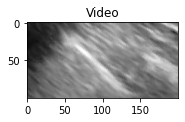

In [8]:
video = 0

ani = plot_video(dataset[video][1])
print(dataset[video][0])
HTML(ani.to_html5_video())

In [9]:
# Get the devices available and set the batch size
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    batch_size = 1
else:
    batch_size = 4*8
    # batch_size = 8

In [10]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True)

In [11]:
sparse_layer = ConvSparseLayer(in_channels=1,
                               out_channels=64,
                               kernel_size=(5, 15, 15),
                               stride=1,
                               padding=(0, 7, 7),
                               convo_dim=3,
                               rectifier=True,
                               leaky=False,
                               lam=0.05,
                               max_activation_iter=200,
                               activation_lr=1e-1)
model = sparse_layer
model = torch.nn.DataParallel(model, device_ids=[1, 0, 2, 3])
model.to(device)

#optimizer = torch.optim.Adam(sparse_layer.parameters(),
#                             lr=3.0e-02)
optimizer = torch.optim.SGD(sparse_layer.parameters(),
                            momentum=0.9,
                            lr=1e-4)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-7, max_lr=1.0e-01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, steps_per_epoch=len(data_loader), epochs=30)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-1, step_size_up=360)

In [ ]:
# for g in optimizer.param_groups:
#     g['lr'] = 5e-4

In [ ]:
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-1, steps_per_epoch=len(data_loader), epochs=15)
# sparse_layer.max_activation_iter=200

In [12]:
best = float('inf')
loss_log = []

In [13]:
for epoch in tqdm(range(30)):
    act_sum = None
    epoch_loss = 0
    act_num = 0
    act_denom = 0
    # for local_batch in train_loader:
    for labels, local_batch, filenames in data_loader:
        local_batch = local_batch.to(device)

        activations = model(local_batch)
        act_num += len(activations[activations>0])
        act_denom += len(activations.flatten())

        if act_sum is None:
            act_sum = (activations > 0).int().sum(0).sum(1).sum(1).sum(1).cpu()
        else:
            act_sum += (activations > 0).int().sum(0).sum(1).sum(1).sum(1).cpu()

        loss = sparse_layer.loss(local_batch, activations)
        epoch_loss += loss.item() * local_batch.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
        sparse_layer.normalize_weights()
        # print(loss)


    # scheduler.step()
    epoch_loss /= len(data_loader.sampler)
    loss_log.append(epoch_loss)
    print("Epoch Loss: {}; Percent active: {}".format(epoch_loss, act_num / act_denom))
    
    # plt.plot(loss_log)
    # plt.title("Loss over training epochs (final loss={:0.2f})".format(loss_log[-1]))
    # plt.savefig("loss_log.png")
    # plt.clf()

  3%|▎         | 1/30 [28:25<13:44:17, 1705.42s/it]

Epoch Loss: 571.5057040690838; Percent active: 0.11778112287438933


  7%|▋         | 2/30 [51:56<11:54:56, 1532.03s/it]

Epoch Loss: 413.25281403952636; Percent active: 0.1390064908927565


 10%|█         | 3/30 [1:20:18<12:04:19, 1609.61s/it]

Epoch Loss: 407.850543068388; Percent active: 0.13902291666666666


 13%|█▎        | 4/30 [1:47:14<11:38:36, 1612.16s/it]

Epoch Loss: 406.01577663600824; Percent active: 0.13823637832934046


 17%|█▋        | 5/30 [2:13:54<11:09:55, 1607.84s/it]

Epoch Loss: 403.63579598605656; Percent active: 0.1375731666607948


 20%|██        | 6/30 [2:38:52<10:28:10, 1570.44s/it]

Epoch Loss: 402.2363290768824; Percent active: 0.13763604759723788


 23%|██▎       | 7/30 [3:03:21<9:49:17, 1537.26s/it] 

Epoch Loss: 401.72139953590346; Percent active: 0.13797862733699737


 27%|██▋       | 8/30 [3:27:28<9:13:07, 1508.52s/it]

Epoch Loss: 400.96744774463974; Percent active: 0.13677216595030064


 30%|███       | 9/30 [3:51:56<8:43:36, 1496.04s/it]

Epoch Loss: 400.75348399268734; Percent active: 0.13564094765830514


 33%|███▎      | 10/30 [4:15:59<8:13:10, 1479.55s/it]

Epoch Loss: 399.2594297596137; Percent active: 0.13384356518343668


 37%|███▋      | 11/30 [4:40:53<7:49:59, 1484.16s/it]

Epoch Loss: 398.8675944813209; Percent active: 0.13501895712960355


 40%|████      | 12/30 [5:05:53<7:26:39, 1488.88s/it]

Epoch Loss: 399.61843251626505; Percent active: 0.13687344557379744


 43%|████▎     | 13/30 [5:31:08<7:04:02, 1496.65s/it]

Epoch Loss: 399.29484363715034; Percent active: 0.13828749721086997


 47%|████▋     | 14/30 [5:55:49<6:37:52, 1492.06s/it]

Epoch Loss: 400.19163813083884; Percent active: 0.1391203672550263


 50%|█████     | 15/30 [6:19:46<6:08:50, 1475.34s/it]

Epoch Loss: 399.9477456260202; Percent active: 0.13858584281637543


 53%|█████▎    | 16/30 [6:44:08<5:43:20, 1471.46s/it]

Epoch Loss: 400.06235015307186; Percent active: 0.1381417926179068


 57%|█████▋    | 17/30 [7:08:57<5:19:56, 1476.63s/it]

Epoch Loss: 399.5035348094437; Percent active: 0.13732236441892146


 60%|██████    | 18/30 [7:33:02<4:53:27, 1467.28s/it]

Epoch Loss: 400.3568889355579; Percent active: 0.13799257005120255


 63%|██████▎   | 19/30 [7:57:25<4:28:43, 1465.81s/it]

Epoch Loss: 400.0925268540925; Percent active: 0.13782980699220218


 67%|██████▋   | 20/30 [8:22:18<4:05:40, 1474.04s/it]

Epoch Loss: 400.04957612104675; Percent active: 0.13843604480810787


 70%|███████   | 21/30 [8:47:12<3:41:59, 1479.97s/it]

Epoch Loss: 400.8113941879301; Percent active: 0.13988323409902292


 73%|███████▎  | 22/30 [9:12:06<3:17:55, 1484.39s/it]

Epoch Loss: 400.7549255898643; Percent active: 0.13980844313697857


 77%|███████▋  | 23/30 [9:37:12<2:53:54, 1490.70s/it]

Epoch Loss: 400.65256854332915; Percent active: 0.14054840828753287


 80%|████████  | 24/30 [10:02:17<2:29:29, 1494.96s/it]

Epoch Loss: 400.2262079983625; Percent active: 0.139541015625


 83%|████████▎ | 25/30 [10:27:14<2:04:38, 1495.62s/it]

Epoch Loss: 399.4490166871631; Percent active: 0.13944908061466554


 87%|████████▋ | 26/30 [10:52:22<1:39:57, 1499.35s/it]

Epoch Loss: 399.7840832492007; Percent active: 0.1404250623884348


 90%|█████████ | 27/30 [11:17:26<1:15:02, 1500.76s/it]

Epoch Loss: 400.21525154558174; Percent active: 0.14269291810527057


 93%|█████████▎| 28/30 [11:42:26<50:01, 1500.63s/it]  

Epoch Loss: 400.739897798569; Percent active: 0.13979781405604097


 97%|█████████▋| 29/30 [12:07:47<25:06, 1506.75s/it]

Epoch Loss: 400.91260427355274; Percent active: 0.139670875757469


100%|██████████| 30/30 [12:33:26<00:00, 1506.89s/it]

Epoch Loss: 401.1702029670105; Percent active: 0.14040062535231115


In [ ]:
print("Percent active: {}".format(act_num / act_denom))

In [ ]:
loss_log[-1]

In [ ]:
plt.plot(loss_log[1:])
# plt.ylim(500, 700)

In [ ]:
min(loss_log)

In [ ]:
plt.plot(loss_log[-90:])

In [ ]:
len(activations[activations>0])/len(activations.flatten())

In [ ]:
activations.flatten().shape

In [ ]:
plt.plot(sorted(list(activations[0].squeeze().abs().sum(1).sum(1).cpu().numpy()), reverse=True))

In [ ]:
ani = plot_filters(sparse_layer.filters.cpu().detach())
HTML(ani.to_html5_video())

In [ ]:
ani = plot_video(dataset[1100][1])
HTML(ani.to_html5_video())

In [ ]:
# 5, 34
f = 3
v = 1100
act = model(dataset[v][1].unsqueeze(0))
subact = torch.zeros_like(act)
subact[:, f] = act[:, f]
# plt.imshow(act[f], cmap="jet")
recon = sparse_layer.reconstructions(subact).squeeze(0).detach().cpu().numpy()
ani = plot_video(recon)
HTML(ani.to_html5_video())

In [ ]:
subact = torch.zeros_like(act)
for x in range(15):
    subact[:, act_idx[x][1]] = act[:, act_idx[x][1]]
# plt.imshow(act[f], cmap="jet")
recon = sparse_layer.reconstructions(subact).squeeze(0).detach().cpu().numpy()
ani = plot_video(recon)
HTML(ani.to_html5_video())

In [ ]:
subact = torch.tensor(act)
print(subact.shape)
# (313.25714, 56),
#  (132.64676, 63),
#  (129.76068, 21),
#  (120.53765, 39),
#  (120.193306, 33),
#  (115.0895, 3),
for x in range(15):
    subact[:, act_idx[x][1]] = 0
# plt.imshow(act[f], cmap="jet")
recon = sparse_layer.reconstructions(subact).squeeze(0).detach().cpu().numpy()
ani = plot_video(recon)
HTML(ani.to_html5_video())

In [ ]:
# 5, 34
act = model(dataset[v][1].unsqueeze(0)).squeeze().cpu().detach().numpy()
# act[f].shape
plt.imshow(act[45], cmap="jet")

In [ ]:
act_idx = sorted([(v,i) for i,v in enumerate(act.squeeze()[:, 60:150, 60:200].sum(1).sum(1))], reverse=True)
act_idx

In [ ]:
optimizer = torch.optim.SGD(sparse_layer.parameters(),
                            momentum=0.9,
                            lr=1e-5)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-7, max_lr=1.0e-01)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(data_loader), epochs=100)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-10, max_lr=1e-2, step_size_up=(17*43)//2+1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=None, epochs=17, steps_per_epoch=43)

In [ ]:
lrs = []
momentums = []
for i in range(17*43):
    scheduler.step()
    for g in optimizer.param_groups:
        lrs.append(g['lr'])
        momentums.append(g['momentum'])
        # print(g['lr'], g['momentum'])
plt.plot(lrs)

In [ ]:
lrs[-1]

In [14]:
torch.save({'model_state_dict': model.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),},
           "saved_models/sparse_conv3d_model-pleural_clips2_5x15x15-11-14-21.pt")

In [ ]:
checkpoint = torch.load("saved_models/sparse_conv3d_model-pleural_clips2_5x15x15-11-14-21.pt")
sparse_layer.load_state_dict(checkpoint['model_state_dict'])